In [1]:
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
import torch.nn.functional as F
from torchvision import models

import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, confusion_matrix ,roc_curve
import seaborn as sns

In [2]:
chunk_size = 5

# List of Parquet file paths
file_paths = [
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
]

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Create a Parquet file reader object
    parquet_file = pq.ParquetFile(file_path)
    
    # Determine the total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Calculate the number of chunks
    num_chunks = total_rows // chunk_size + (1 if total_rows % chunk_size else 0)
    
    # Loop over the file in chunks
    for chunk_index in range(num_chunks):
        # Read a chunk of rows from the file
        chunk = parquet_file.read_row_group(chunk_index, columns=None)
        df = chunk.to_pandas()
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

In [3]:
def to_3d(arr):
    vishak=[]
    for i in range (0,3):
        vis=np.stack(np.stack(arr)[i],axis=-1)
        vishak.append(vis)
    vishak=np.array(vishak)
    vishak = (vishak - vishak.min())/(vishak.max()- vishak.min())
    return vishak

In [4]:
data["X_jets"]  = data["X_jets"].apply(to_3d)

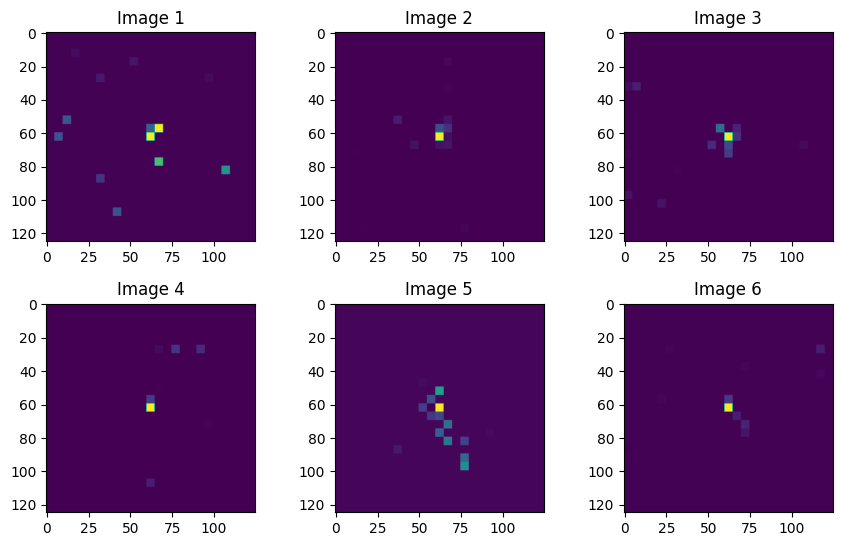

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Loop over the axes and image ids, and plot each image on a separate subplot
for i, ax in enumerate(axes.flatten()):
    image = data['X_jets'][i][2,:,:]
    ax.imshow(image)
    ax.set_title(f'Image {i+1}')
    
# Adjust spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

# Show the plot
plt.show()

In [6]:
data.columns

Index(['X_jets', 'pt', 'm0', 'y'], dtype='object')

In [7]:
# data['y']

In [8]:
class task2Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Assuming 'X_jets' column contains paths to images or actual image data
        X = self.dataframe.iloc[idx]['X_jets']
        mean = X.mean(axis=(0, 1, 2), keepdims=True)
        std = X.std(axis=(0, 1, 2), keepdims=True)

        # Normalize each channel separately
        X = (X - mean) / std
        y = self.dataframe.iloc[idx]['y']
        
        if self.transform:
            X = self.transform(X)
        
        # Convert X and y to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float)
        y_tensor = torch.tensor(y, dtype=torch.long)

        return X_tensor, y_tensor


In [9]:
jet_dataset = task2Dataset(dataframe=data)


train_dataset, val_dataset = train_test_split(jet_dataset, test_size=0.2, random_state=42)


train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [10]:
next(iter(train_loader))[0].shape

torch.Size([256, 3, 125, 125])

In [11]:
class CustomMobileNetV3(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(CustomMobileNetV3, self).__init__()
        self.model = timm.create_model('mobilenetv3_large_100', pretrained=pretrained, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize your model
model = CustomMobileNetV3(num_classes=2, pretrained=True)
print(model)

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

CustomMobileNetV3(
  (model): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (se): Identity()
          (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (drop_path): 

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [13]:
num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []
best_loss = 100000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train] Loss: 0.0000", leave=False)
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train] Loss: {loss.item():.4f}")
    
    #scheduler.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val] Loss: 0.0000, Acc: 0.0000", leave=True)
    
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            
            val_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Val] Loss: {loss.item():.4f}, Acc: {correct_predictions/total_predictions:.4f}")
    
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    epoch_val_accuracy = correct_predictions / total_predictions
    best_loss = min(epoch_val_loss , best_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    if(epoch_val_loss== best_loss):
        
            model_path = f"model_weights_{epoch}.pth"
            torch.save(model.state_dict(), model_path)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")


Epoch 1/20 [Val] Loss: 1.3562, Acc: 0.6140: 100%|██████████| 175/175 [00:02<00:00, 77.07it/s]


Epoch 1/20, Train Loss: 1.6215, Val Loss: 1.3205, Val Accuracy: 0.6140


Epoch 2/20 [Val] Loss: 2.2744, Acc: 0.5957: 100%|██████████| 175/175 [00:02<00:00, 86.00it/s]


Epoch 2/20, Train Loss: 0.7658, Val Loss: 1.1611, Val Accuracy: 0.5957


Epoch 3/20 [Val] Loss: 1.0439, Acc: 0.6167: 100%|██████████| 175/175 [00:02<00:00, 85.13it/s]


Epoch 3/20, Train Loss: 0.4585, Val Loss: 1.1312, Val Accuracy: 0.6167


Epoch 4/20 [Val] Loss: 1.1395, Acc: 0.6162: 100%|██████████| 175/175 [00:02<00:00, 85.85it/s]


Epoch 4/20, Train Loss: 0.2882, Val Loss: 1.1945, Val Accuracy: 0.6162


Epoch 5/20 [Val] Loss: 0.9942, Acc: 0.6280: 100%|██████████| 175/175 [00:02<00:00, 79.54it/s]


Epoch 5/20, Train Loss: 0.1945, Val Loss: 1.2929, Val Accuracy: 0.6280


Epoch 6/20 [Val] Loss: 1.6614, Acc: 0.6277: 100%|██████████| 175/175 [00:02<00:00, 81.46it/s]


Epoch 6/20, Train Loss: 0.1264, Val Loss: 1.2533, Val Accuracy: 0.6277


Epoch 7/20 [Val] Loss: 1.2670, Acc: 0.6200: 100%|██████████| 175/175 [00:02<00:00, 84.18it/s]


Epoch 7/20, Train Loss: 0.0895, Val Loss: 1.2824, Val Accuracy: 0.6200


Epoch 8/20 [Val] Loss: 2.1079, Acc: 0.6097: 100%|██████████| 175/175 [00:02<00:00, 83.59it/s]


Epoch 8/20, Train Loss: 0.0871, Val Loss: 1.5093, Val Accuracy: 0.6097


Epoch 9/20 [Val] Loss: 1.0984, Acc: 0.6343: 100%|██████████| 175/175 [00:02<00:00, 81.01it/s]


Epoch 9/20, Train Loss: 0.0725, Val Loss: 1.3199, Val Accuracy: 0.6343


Epoch 10/20 [Val] Loss: 1.4849, Acc: 0.6216: 100%|██████████| 175/175 [00:02<00:00, 86.05it/s]


Epoch 10/20, Train Loss: 0.0487, Val Loss: 1.3603, Val Accuracy: 0.6216


Epoch 11/20 [Val] Loss: 0.9186, Acc: 0.6286: 100%|██████████| 175/175 [00:02<00:00, 77.76it/s]


Epoch 11/20, Train Loss: 0.0513, Val Loss: 1.3699, Val Accuracy: 0.6286


Epoch 12/20 [Val] Loss: 1.5534, Acc: 0.6287: 100%|██████████| 175/175 [00:02<00:00, 80.76it/s]


Epoch 12/20, Train Loss: 0.0351, Val Loss: 1.4242, Val Accuracy: 0.6287


Epoch 13/20 [Val] Loss: 1.0609, Acc: 0.6426: 100%|██████████| 175/175 [00:02<00:00, 82.66it/s]


Epoch 13/20, Train Loss: 0.0437, Val Loss: 1.4481, Val Accuracy: 0.6426


Epoch 14/20 [Val] Loss: 0.7483, Acc: 0.6289: 100%|██████████| 175/175 [00:02<00:00, 87.00it/s]


Epoch 14/20, Train Loss: 0.0426, Val Loss: 1.4582, Val Accuracy: 0.6289


Epoch 15/20 [Val] Loss: 1.6908, Acc: 0.6418: 100%|██████████| 175/175 [00:02<00:00, 75.40it/s]


Epoch 15/20, Train Loss: 0.0365, Val Loss: 1.5151, Val Accuracy: 0.6418


Epoch 16/20 [Val] Loss: 1.1506, Acc: 0.6386: 100%|██████████| 175/175 [00:02<00:00, 84.99it/s]


Epoch 16/20, Train Loss: 0.0247, Val Loss: 1.4569, Val Accuracy: 0.6386


Epoch 17/20 [Val] Loss: 0.6856, Acc: 0.6531: 100%|██████████| 175/175 [00:02<00:00, 83.34it/s]


Epoch 17/20, Train Loss: 0.0337, Val Loss: 1.4910, Val Accuracy: 0.6531


Epoch 18/20 [Val] Loss: 0.7186, Acc: 0.6474: 100%|██████████| 175/175 [00:02<00:00, 82.40it/s]


Epoch 18/20, Train Loss: 0.0265, Val Loss: 1.6061, Val Accuracy: 0.6474


Epoch 19/20 [Val] Loss: 1.9122, Acc: 0.6393: 100%|██████████| 175/175 [00:02<00:00, 85.85it/s]


Epoch 19/20, Train Loss: 0.0391, Val Loss: 1.5254, Val Accuracy: 0.6393


Epoch 20/20 [Val] Loss: 1.8346, Acc: 0.6436: 100%|██████████| 175/175 [00:02<00:00, 80.00it/s]

Epoch 20/20, Train Loss: 0.0325, Val Loss: 1.6046, Val Accuracy: 0.6436


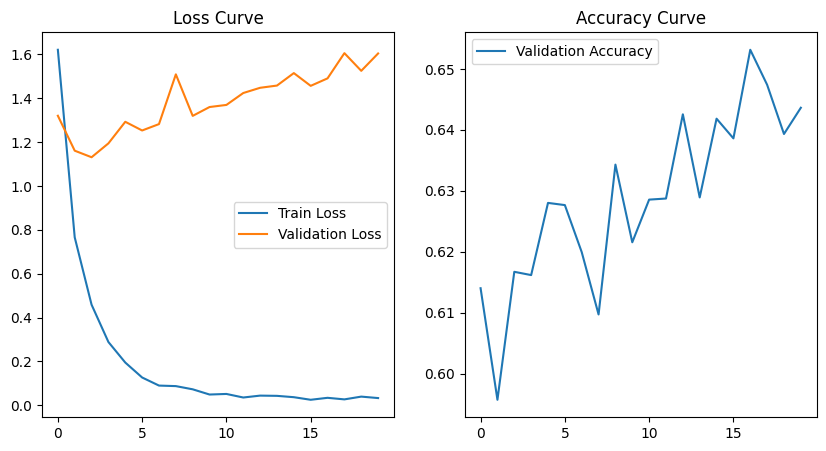

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()
